# Exploración con support vector machine

In [5]:
# Importamos librerias necesarias para realizar el analisis. 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import parallel_coordinates

# SVM
from sklearn.model_selection import (
    train_test_split,   
    StratifiedKFold,    
    GridSearchCV     
)
from sklearn.svm import SVC     
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score
)

# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# Configuramos las opciones de pandas y seaborn para mejorar la visualización de datos.
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Cargamos el dataset de diabetes y mostramos su tamaño.
df = pd.read_csv('../data/processed/diabetes_sample.csv')


In [6]:
y = df['Diabetes_012']
X = df.drop(columns=["Diabetes_012"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

model_svm = SVC(class_weight='balanced', random_state=2)

params = model_svm.get_params()
print("\nParámetros del modelo SVM:")
for param, valor in sorted(params.items()):
    print(f"{param:25s} = {valor}")


Parámetros del modelo SVM:
C                         = 1.0
break_ties                = False
cache_size                = 200
class_weight              = balanced
coef0                     = 0.0
decision_function_shape   = ovr
degree                    = 3
gamma                     = scale
kernel                    = rbf
max_iter                  = -1
probability               = False
random_state              = 2
shrinking                 = True
tol                       = 0.001
verbose                   = False


In [8]:
param_grid_svm = {
    'kernel': ['linear', 'rbf'],   
    'C': [0.01, 0.1, 1, 10],            
    'gamma': ['scale', 'auto']  
}

grid_search_svm = GridSearchCV(
    estimator=model_svm,               
    param_grid=param_grid_svm,
    scoring='balanced_accuracy',            
    cv=cv,                      
    n_jobs=-1,                    
    verbose=2,
    return_train_score=True,    

)

# Entrenamiento con búsqueda de hiperparámetros
grid_search_svm.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,SVC(class_wei...andom_state=2)
,param_grid,"{'C': [0.01, 0.1, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,C,1


In [ ]:
print("\nMejores parámetros encontrados:", grid_search_svm.best_params_)


best_model_svm = grid_search_svm.best_estimator_
print("\nMejor modelo entrenado:\n", best_model_svm)


Mejores parámetros encontrados: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Mejor modelo entrenado:
 SVC(C=1, class_weight='balanced', kernel='linear', random_state=2)


In [ ]:
results = pd.DataFrame(grid_search_svm.cv_results_)

# Seleccionar columnas relevantes para SVM
columns_target = [
    'param_kernel',
    'param_C',
    'param_gamma',
    'mean_train_score',
    'std_train_score',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

# Subset ordenado por el ranking del score
results_subset_svm = results[columns_target].copy()
results_subset_svm = results_subset_svm.sort_values(by='rank_test_score')

print("\nResultados resumidos de la búsqueda ordenados por score:")
print(results_subset_svm.to_string(index=False))


Resultados resumidos de la búsqueda ordenados por score:
param_kernel  param_C param_gamma  mean_train_score  std_train_score  mean_test_score  std_test_score  rank_test_score
      linear    10.00       scale          0.519335         0.006588         0.501162        0.008958                1
      linear    10.00        auto          0.519335         0.006588         0.501162        0.008958                1
      linear     1.00        auto          0.519354         0.006866         0.501162        0.008789                1
      linear     1.00       scale          0.519354         0.006866         0.501162        0.008789                1
      linear     0.10        auto          0.519521         0.007079         0.499429        0.007855                5
      linear     0.10       scale          0.519521         0.007079         0.499429        0.007855                5
      linear     0.01       scale          0.519545         0.007166         0.498239        0.006078        

In [ ]:
# Obtener el mejor índice del GridSearch de SVM
results_svm = pd.DataFrame(grid_search_svm.cv_results_)
best_index = grid_search_svm.best_index_
best_row = results_svm.loc[best_index]

# Extraer los puntajes de entrenamiento y validación
mean_cv_score = best_row['mean_test_score']
mean_train_score = best_row['mean_train_score']

# Calcular el gap de overfitting
overfitting_gap = mean_train_score - mean_cv_score

print(f"Gap (Train - CV): {overfitting_gap:.4f}")

# Interpretación del gap
if overfitting_gap > 0.05:  # Umbral de ejemplo, ajustable
    print("Posible Overfitting: El modelo funciona mucho mejor en entrenamiento que en validación.")
elif overfitting_gap < 0.01:
    print("Generalización Sólida: El rendimiento de entrenamiento y validación es muy similar.")
else:
    print("Generalización Aceptable: Existe una pequeña diferencia, típica en el modelado.")


Gap (Train - CV): 0.0182
Generalización Aceptable: Existe una pequeña diferencia, típica en el modelado.



MÉTRICAS DE CLASIFICACIÓN EN TEST
Balanced Accuracy: 0.5376356102702438
Accuracy: 0.6326369728025226
Precision (macro): 0.4431093573540639
F1-score (macro): 0.42450468421758547

REPORTE DETALLADO

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.96      0.63      0.76      6412
         1.0       0.03      0.27      0.06       139
         2.0       0.34      0.71      0.46      1060

    accuracy                           0.63      7611
   macro avg       0.44      0.54      0.42      7611
weighted avg       0.86      0.63      0.70      7611



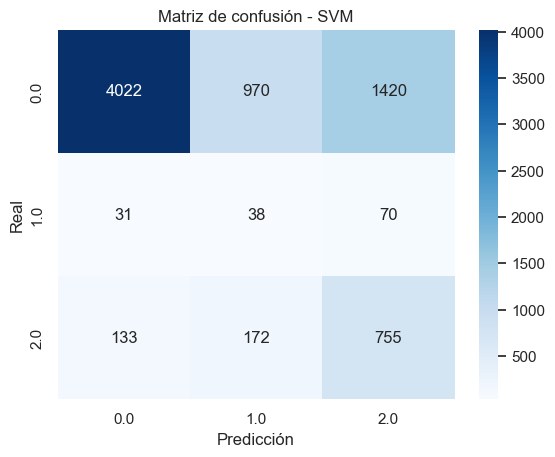

In [ ]:
y_pred = best_model_svm.predict(X_test_scaled)

# Métricas de evaluación
print("\nMÉTRICAS DE CLASIFICACIÓN EN TEST")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nREPORTE DETALLADO")
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - SVM")
plt.show()

In [ ]:
cv_ba = grid_search_svm.best_score_

# Balanced Accuracy en entrenamiento
y_pred_train = best_model_svm.predict(X_train_scaled)
ba_train = balanced_accuracy_score(y_train, y_pred_train)

# Balanced Accuracy en prueba
y_pred_test = best_model_svm.predict(X_test_scaled)
ba_test = balanced_accuracy_score(y_test, y_pred_test)

# Comparativa final
print("\n--- Balanced Accuracy (BA) Comparativa Final ---")
print(f"Train:           BA = {ba_train:.4f}")
print(f"Validation (CV): BA = {cv_ba:.4f}")
print(f"Test:            BA = {ba_test:.4f}")



--- Balanced Accuracy (BA) Comparativa Final ---
Train:           BA = 0.5098
Validation (CV): BA = 0.5012
Test:            BA = 0.5376


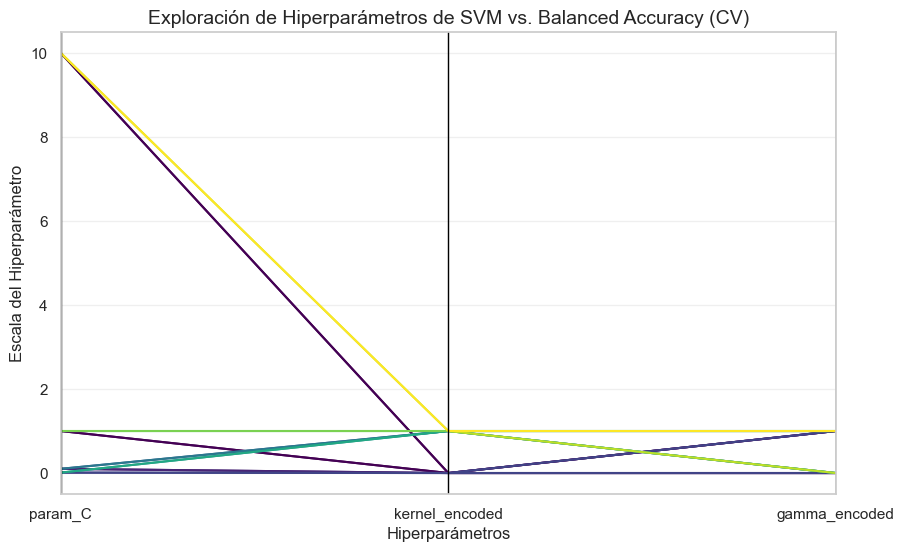

In [11]:
results_svm = pd.DataFrame(grid_search_svm.cv_results_)
results_svm = results_svm.rename(columns={'mean_test_score': 'Balanced_Accuracy_CV'})

# Seleccionar hiperparámetros relevantes
data_for_plot = results_svm[[
    'param_C',
    'param_kernel',
    'param_gamma',
    'Balanced_Accuracy_CV'
]].copy()

# Codificar kernel (categoría → número)
kernel_mapping = {k: i for i, k in enumerate(data_for_plot['param_kernel'].unique())}
data_for_plot['kernel_encoded'] = data_for_plot['param_kernel'].map(kernel_mapping)

# Codificar gamma (categoría → número)
gamma_mapping = {g: i for i, g in enumerate(data_for_plot['param_gamma'].unique())}
data_for_plot['gamma_encoded'] = data_for_plot['param_gamma'].map(gamma_mapping)

# Ordenar por desempeño
data_for_plot = data_for_plot.sort_values(by='Balanced_Accuracy_CV', ascending=False)

# Gráfico de coordenadas paralelas
plt.figure(figsize=(10, 6))
parallel_coordinates(
    data_for_plot,
    class_column='Balanced_Accuracy_CV',
    cols=['param_C', 'kernel_encoded', 'gamma_encoded'],
    colormap='viridis'
)

plt.title('Exploración de Hiperparámetros de SVM vs. Balanced Accuracy (CV)', fontsize=14)
plt.xlabel('Hiperparámetros')
plt.ylabel('Escala del Hiperparámetro')
plt.grid(True, alpha=0.3)
plt.legend([], [], frameon=False)  # Eliminar leyenda automática
plt.show()
